# Granger Causality between two time series

**The Granger Causality test is used to determine whether one time series is useful in forecasting another time series, from a mechanical perspective. It is not true causality, but really an indication of a predictive relationship.** 

**Essentially, the concept is built on the influence of the coefficient in the prediction formula for one time series over the coefficient of another time series. Recall that in regression analysis, the higher the coefficient, the more significance the variable has on the target output. This is really the same idea except with VARMA models and multiple time series.**

**By passing a maximum number of `p` lags as an argument (`maxlag`), the `grangercausalitytests()` function tests every combination of `p` with several information criteria tests, e.g. AIC, BIC, FPE etc. The function returns a dictionary of mini reports on every `p` order and the effect on each information criterion, where the dictionary key is the `p` lag value.**

**You must choose a significance threshold for the p-value statistic beforehand, and any values below the threshold are deemed significant.**

**Use the US macro-economics dataset to assess the relationship between the GDP Growth and Term Spread (as seen in previous session). Note that each time series must be stationary before running the Granger Causality test, and fortunately we know from the previous session that both GDP Growth differenced and Term Spread are stationary.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
df = pd.read_excel('data/us_macro_quarterly.xlsx')

C:\Users\shmel\Anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


In [4]:
# Function to re-format and parse dates

def parse_date(data):
    # Quarter is in {01,02,03,04}
    year, quarter = data.split(':')
    month = (int(quarter) - 1) * 3 + 1
    s = f"{year}-{month}"
    return datetime.strptime(s, "%Y-%m")

In [5]:
df['Date'] = df['Unnamed: 0'].apply(parse_date)

In [6]:
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,Date
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667,1957-01-01
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333,1957-04-01
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333,1957-07-01
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000,1957-10-01
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667,1958-01-01


In [7]:
# Set Date column as index
df.set_index(df['Date'], inplace=True)

# Drop Date and Unnamed columns
df.drop(['Date', 'Unnamed: 0'], axis=1, inplace=True)

In [8]:
df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


In [9]:
df.index.freq = 'QS'

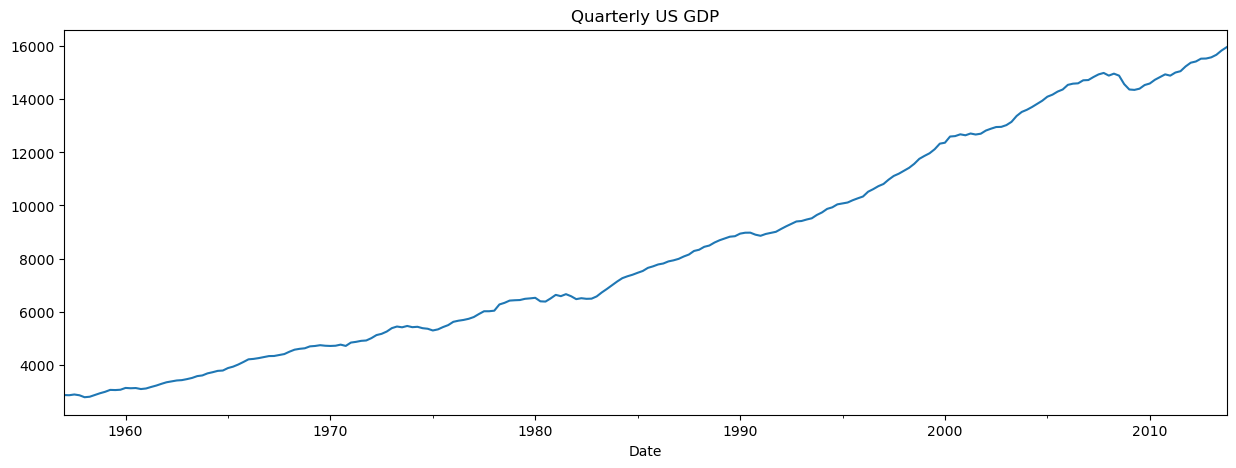

In [10]:
# Recall that GDP has a strong upwards trend

df['GDPC96'].plot(figsize=(15, 5))
plt.title("Quarterly US GDP");

In [11]:
# Calculate GDP Growth and make time series stationary

df['GDPGrowth'] = np.log(df['GDPC96']).diff()

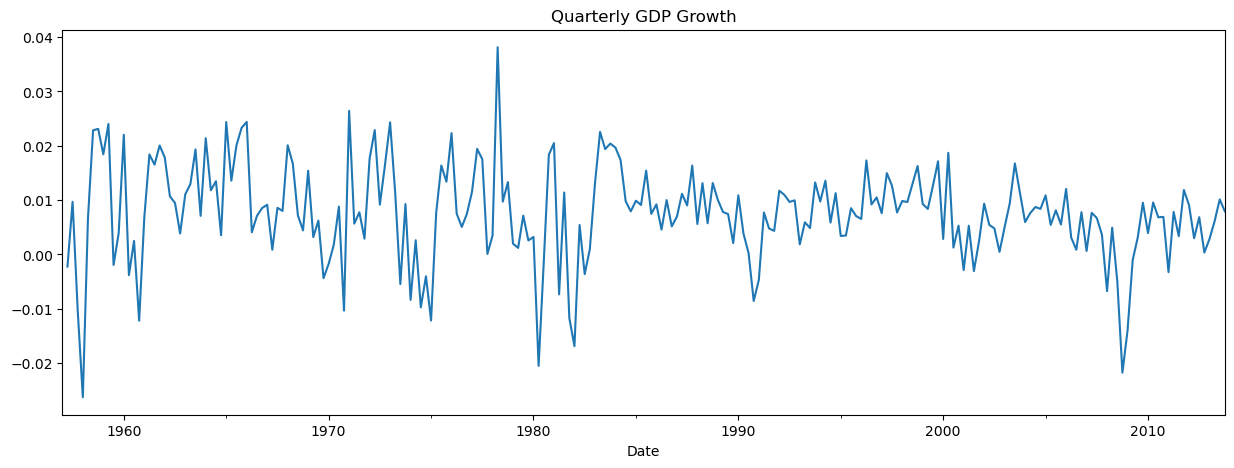

In [12]:
df['GDPGrowth'].plot(figsize=(15, 5))
plt.title("Quarterly GDP Growth");

In [13]:
# Calculate Term Spread (long-term investment rate minus short-term investment rate)

df['TSpread'] = df['GS10'] - df['TB3MS']

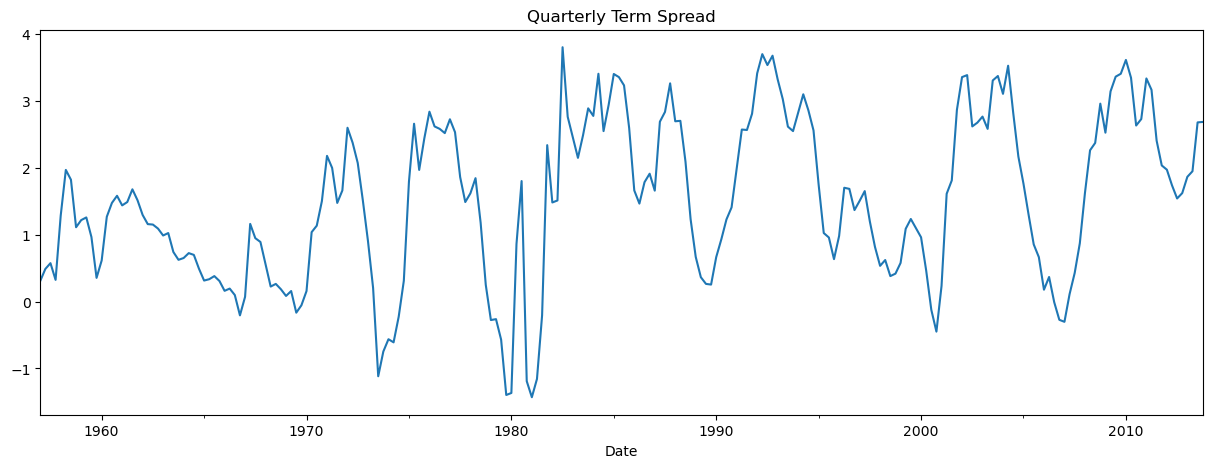

In [14]:
# Recall that Term Spread has more cyclical pattern

df['TSpread'].plot(figsize=(15, 5))
plt.title("Quarterly Term Spread");

In [16]:
# Selected time series

cols = ['GDPGrowth', 'TSpread']

In [15]:
df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,GDPGrowth,TSpread
Date,,,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667,NaN,0.306667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333,-0.002220,0.486667
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333,0.009693,0.573333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000,-0.010303,0.323333
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667,-0.026265,1.283333


In [17]:
# Make copy of selected time series only - remove first null value

df1 = df.iloc[1:][cols].copy()

In [18]:
df1.head()

,GDPGrowth,TSpread
Date,,
1957-04-01,-0.002220,0.486667
1957-07-01,0.009693,0.573333
1957-10-01,-0.010303,0.323333
1958-01-01,-0.026265,1.283333
1958-04-01,0.006577,1.966667


**The Null Hypothesis for Granger Causality tests is that the time series in the second column, x2 or Term Spread, does NOT granger-cause the time series in the first column, x1 or GDP Growth.**

**Grange Causality means that the past values of Term Spread have a statistically significant effect on the current value of GDP Growth, taking past values of GDP Growth into account as regressors, i.e. can Term Spread forecast for GDP Growth.**

**The `grangercausalitytests()` function goes through the time series in the order that they appear in the dataset. You must specify the maximum number of `p` lags allowed in testing (`maxlag` argument), as well as the input time series. The time series are processed in the order they appear in the dataset.**

In [19]:
granger_result = grangercausalitytests(df1, maxlag=18)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1781  , p=0.0137  , df_denom=223, df_num=1
ssr based chi2 test:   chi2=6.2612  , p=0.0123  , df=1
likelihood ratio test: chi2=6.1761  , p=0.0129  , df=1
parameter F test:         F=6.1781  , p=0.0137  , df_denom=223, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9160  , p=0.0082  , df_denom=220, df_num=2
ssr based chi2 test:   chi2=10.0555 , p=0.0066  , df=2
likelihood ratio test: chi2=9.8373  , p=0.0073  , df=2
parameter F test:         F=4.9160  , p=0.0082  , df_denom=220, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4458  , p=0.0176  , df_denom=217, df_num=3
ssr based chi2 test:   chi2=10.6710 , p=0.0136  , df=3
likelihood ratio test: chi2=10.4246 , p=0.0153  , df=3
parameter F test:         F=3.4458  , p=0.0176  , df_denom=217, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8964  , p=0.0230  

**At 5% significance level (0.05), the coefficients have significance from lags one to six. Then at lags seven and eight, the p-value exceeds the significance level. After that, the coefficients become significant again by p-value dropping below 0.05, from lags nine to eleven. This indicates a pattern but only upto a point.**

**You can reverse the order of the time series, i.e. test whether GDP Growth time series can forecast for Term Spread time series.** 

In [20]:
granger_result = grangercausalitytests(df1[reversed(cols)], maxlag=18)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.9872 , p=0.0006  , df_denom=223, df_num=1
ssr based chi2 test:   chi2=12.1485 , p=0.0005  , df=1
likelihood ratio test: chi2=11.8332 , p=0.0006  , df=1
parameter F test:         F=11.9872 , p=0.0006  , df_denom=223, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4010  , p=0.0051  , df_denom=220, df_num=2
ssr based chi2 test:   chi2=11.0476 , p=0.0040  , df=2
likelihood ratio test: chi2=10.7849 , p=0.0046  , df=2
parameter F test:         F=5.4010  , p=0.0051  , df_denom=220, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8793  , p=0.0026  , df_denom=217, df_num=3
ssr based chi2 test:   chi2=15.1100 , p=0.0017  , df=3
likelihood ratio test: chi2=14.6221 , p=0.0022  , df=3
parameter F test:         F=4.8793  , p=0.0026  , df_denom=217, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.1513  , p=0.0152  

**At 5% significance level (0.05), the coefficients have much greater significance, i.e. the p-value is well below the significance level, throughout all possible combinations of `p` lags. There is also evidence of small cyclical pattern but eventually all lags are significant. This means that GDP Growth can forecast more robustly for Term Spread.**

In [21]:
# View results more closely for p lags of 4

granger_result[4]

({'ssr_ftest': (3.151267553744481, 0.015224073544798216, 214.0, 4),
  'ssr_chi2test': (13.135189990374192, 0.010633778640657026, 4),
  'lrtest': (12.762893995089485, 0.012494367852353487, 4),
  'params_ftest': (3.1512675537444625, 0.015224073544798752, 214.0, 4.0)},
  array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0.]])])

**The second element in tuple above is an array of integers, which are the OLS estimation results.**